In [1]:
#imports
%matplotlib notebook
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.cm as cm
import matplotlib.colors as colors

from functions.utils import n_params, vector_to_state_dict, state_dict_to_vector, get_param_state
from functions.my_optimizers import GDMethod,MomentumMethod, Adagrad, RMSProp,LinearLrUpdate, StepLrUpdate, ExpLrUpdate, CostLrUpdate
from functions.mod_adam import Adam

#generating approximately linear data from python func
from lin_reg_data import getLinRegDatasets

In [2]:
# training parameters

num_epochs = 25
batch_size = 32

lr = 0.001
betas = (0.9, 0.999)

In [3]:
!nvidia-smi

Sat Sep 11 14:54:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   37C    P2    33W / 250W |   1626MiB / 12066MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

In [4]:
device = 'cuda:0'

In [5]:
#init datasets and dataloaders

#setting data parameters
num_train = 5000
num_test = 100
y_dim = 1
x_dim = 1
m_var = 0.25
b_var = 0.25

#setting random number seed for data generation
np.random.seed(seed=0)

train_set, test_set, m, b = getLinRegDatasets(num_train, num_test,
                                            x_dim=x_dim, y_dim=y_dim,
                                            m_var=m_var, b_var=b_var)

train_data = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_set, batch_size=batch_size, shuffle=True)


In [6]:
#defining model, device and loss fn, called Model, device, and loss_fn
#need to add attribute "self.param_updates" that is initialized to 0
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.lin = nn.Linear(x_dim, y_dim)
        self.param_updates = 0

    def forward(self, x):
        return self.lin(x)
    
loss_fn = nn.MSELoss()
model = Model()
model.to(device)

Model(
  (lin): Linear(in_features=1, out_features=1, bias=True)
)

In [7]:
#getting number of parameters in model
num_params = n_params(model, verbose=True)

#defing arrays to store model paramter states as it trains
num_param_states = num_epochs*len([0 for val in train_data])+1
# +1 so that I can include initial parameter state
param_states = np.zeros((num_param_states, num_params))
print('param states shape:', param_states.shape)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=num_param_states)

#the step corresponding to the end of an epoch
epoch_indices = np.zeros((num_epochs+1))

train_loss = np.zeros((num_param_states))
ep_train_loss = np.zeros((num_epochs+1))
test_loss = np.zeros((num_epochs+1))

#storing adam inst. stuff
grads = np.zeros_like(param_states)
m1s = np.zeros_like(param_states)
m2s = np.zeros_like(param_states)

lin.weight size: 1
lin.bias size: 1
Total num. parameters: 2
param states shape: (3926, 2)


In [8]:
def train(dataloader, model, loss_fn, optimizer, param_states,
          train_loss=train_loss, grads=grads, m1s=m1s, m2s=m2s):
    size = len(dataloader)
    
    total_loss = 0.0

    if model.param_updates == 0:
        param_states[model.param_updates] = get_param_state(model)
        model.param_updates += 1

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        grad, m1, m2, _ = optimizer.step()
        
        print(grad)

        grads[model.param_updates-1] = np.concatenate([g.flatten() for g in grad])
        m1s[model.param_updates-1] = np.concatenate([m.flatten() for m in m1])
        m2s[model.param_updates-1] = np.concatenate([m.flatten() for m in m2])
        
        param_states[model.param_updates] = get_param_state(model)

        train_loss[model.param_updates] = loss.item()
        total_loss += loss.item()

        model.param_updates += 1

    return total_loss/size

#function which applies model to test dataset
def test(dataloader, model, loss_fn):
    num_minibatches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_minibatches
    return test_loss

In [9]:
model.param_updates=0

#Choose optimizer

#optimizer = GDMethod(model.parameters(), lr=lr)
#optimizer = MomentumMethod(model.parameters(), lr=lr)
#optimizer = Adagrad(model.parameters(), lr=lr)
#optimizer = RMSProp(model.parameters(), lr=lr, ema_coeff=0.9)
optimizer = Adam(model.parameters(), lr=lr, betas=betas)

#Getting initial train and test loss
train_loss[0] = test(train_data, model, loss_fn)
ep_train_loss[0] = test(train_data, model, loss_fn)  
test_loss[0] = test(test_data, model, loss_fn)

for j in range(num_epochs):
    print(' - Epoch: %i'%(j+1))

    #Choose lr scheduler
    
    #this_lr = LinearLrUpdate(j, lr, optimizer, decay_rate=2)
    #this_lr = StepLrUpdate(j, lr, optimizer, decay_rate=0.9, drop_rate=1)
    #this_lr = ExpLrUpdate(j, lr, optimizer, decay_rate=1)

    ep_train_loss[j+1] = train(train_data, model, loss_fn, optimizer, param_states, train_loss)
    test_loss[j+1] = test(test_data, model, loss_fn)
    epoch_indices[j+1] = model.param_updates-1

steps = param_states[1:] - param_states[:-1]

 - Epoch: 1
[array([[0.43648103]], dtype=float32), array([0.7183089], dtype=float32)]
[array([[0.3259743]], dtype=float32), array([0.5912318], dtype=float32)]
[array([[0.3675671]], dtype=float32), array([0.62302935], dtype=float32)]
[array([[0.3053008]], dtype=float32), array([0.55254173], dtype=float32)]
[array([[0.23702538]], dtype=float32), array([0.47063342], dtype=float32)]
[array([[0.28083438]], dtype=float32), array([0.56243443], dtype=float32)]
[array([[0.280927]], dtype=float32), array([0.56425846], dtype=float32)]
[array([[0.31762654]], dtype=float32), array([0.5219141], dtype=float32)]
[array([[0.33830115]], dtype=float32), array([0.60228807], dtype=float32)]
[array([[0.21208881]], dtype=float32), array([0.44962347], dtype=float32)]
[array([[0.2821548]], dtype=float32), array([0.5392294], dtype=float32)]
[array([[0.36526164]], dtype=float32), array([0.60452557], dtype=float32)]
[array([[0.2005439]], dtype=float32), array([0.35647684], dtype=float32)]
[array([[0.3685699]], dt

[array([[0.18490806]], dtype=float32), array([0.35961843], dtype=float32)]
[array([[0.04947056]], dtype=float32), array([0.12461226], dtype=float32)]
[array([[0.17869677]], dtype=float32), array([0.30732602], dtype=float32)]
[array([[0.16165964]], dtype=float32), array([0.25036484], dtype=float32)]
[array([[0.19501473]], dtype=float32), array([0.31770653], dtype=float32)]
[array([[0.1928261]], dtype=float32), array([0.3331015], dtype=float32)]
[array([[0.13153452]], dtype=float32), array([0.21524252], dtype=float32)]
[array([[0.17167428]], dtype=float32), array([0.27041698], dtype=float32)]
[array([[0.0979115]], dtype=float32), array([0.19747402], dtype=float32)]
[array([[0.19381684]], dtype=float32), array([0.27773726], dtype=float32)]
[array([[0.1775007]], dtype=float32), array([0.27248633], dtype=float32)]
[array([[0.11105755]], dtype=float32), array([0.20518379], dtype=float32)]
[array([[0.17302105]], dtype=float32), array([0.2835364], dtype=float32)]
[array([[0.16851029]], dtype=f

[array([[0.06389423]], dtype=float32), array([0.08220196], dtype=float32)]
[array([[0.00646057]], dtype=float32), array([0.00276893], dtype=float32)]
[array([[-0.00638418]], dtype=float32), array([-0.0019506], dtype=float32)]
[array([[0.0099669]], dtype=float32), array([0.12636754], dtype=float32)]
[array([[0.04207496]], dtype=float32), array([0.08197723], dtype=float32)]
[array([[0.05450981]], dtype=float32), array([0.07757657], dtype=float32)]
[array([[0.04157044]], dtype=float32), array([0.07375909], dtype=float32)]
[array([[-0.0341343]], dtype=float32), array([-0.03435177], dtype=float32)]
[array([[0.074307]], dtype=float32), array([0.13716581], dtype=float32)]
[array([[0.01085261]], dtype=float32), array([-0.00387738], dtype=float32)]
[array([[-0.0138488]], dtype=float32), array([0.03673988], dtype=float32)]
[array([[0.06280725]], dtype=float32), array([0.14524941], dtype=float32)]
[array([[0.10021318]], dtype=float32), array([0.17125729], dtype=float32)]
[array([[0.06966595]], dt

[array([[0.00209123]], dtype=float32), array([-0.03492195], dtype=float32)]
[array([[0.03376612]], dtype=float32), array([0.06406656], dtype=float32)]
[array([[-0.03657632]], dtype=float32), array([-0.05500593], dtype=float32)]
[array([[0.02093411]], dtype=float32), array([0.05666413], dtype=float32)]
[array([[0.06065243]], dtype=float32), array([0.10695005], dtype=float32)]
[array([[0.03271574]], dtype=float32), array([-0.01894735], dtype=float32)]
[array([[0.00943426]], dtype=float32), array([-0.06005276], dtype=float32)]
[array([[-0.00575958]], dtype=float32), array([-0.06410105], dtype=float32)]
[array([[0.00430048]], dtype=float32), array([0.0219595], dtype=float32)]
[array([[-0.03450366]], dtype=float32), array([-0.0200066], dtype=float32)]
[array([[0.06381771]], dtype=float32), array([0.05296012], dtype=float32)]
[array([[0.01370963]], dtype=float32), array([0.01009196], dtype=float32)]
[array([[0.02889941]], dtype=float32), array([0.01315537], dtype=float32)]
[array([[0.0413577

[array([[-0.011843]], dtype=float32), array([-0.03221375], dtype=float32)]
[array([[0.02129067]], dtype=float32), array([0.04446049], dtype=float32)]
[array([[-0.07528272]], dtype=float32), array([-0.14727661], dtype=float32)]
[array([[0.03752676]], dtype=float32), array([0.03774199], dtype=float32)]
[array([[0.02217202]], dtype=float32), array([0.04621857], dtype=float32)]
[array([[-0.04375213]], dtype=float32), array([-0.09856637], dtype=float32)]
[array([[-0.0034993]], dtype=float32), array([-0.053032], dtype=float32)]
[array([[0.00505886]], dtype=float32), array([0.00408905], dtype=float32)]
[array([[-0.0356534]], dtype=float32), array([-0.00477764], dtype=float32)]
[array([[-0.01754049]], dtype=float32), array([-0.02954347], dtype=float32)]
[array([[0.01326927]], dtype=float32), array([0.03292207], dtype=float32)]
[array([[0.00222292]], dtype=float32), array([0.00746947], dtype=float32)]
[array([[0.03996127]], dtype=float32), array([0.06030828], dtype=float32)]
[array([[-0.0671856

[array([[0.04304195]], dtype=float32), array([0.08320676], dtype=float32)]
[array([[0.03137859]], dtype=float32), array([0.03207752], dtype=float32)]
[array([[-0.00774146]], dtype=float32), array([-0.02313822], dtype=float32)]
[array([[-0.00512667]], dtype=float32), array([0.01384459], dtype=float32)]
[array([[-0.07049015]], dtype=float32), array([-0.10570781], dtype=float32)]
[array([[-0.00478968]], dtype=float32), array([-0.00775245], dtype=float32)]
[array([[0.0271103]], dtype=float32), array([0.06828417], dtype=float32)]
[array([[0.03635176]], dtype=float32), array([0.04346339], dtype=float32)]
[array([[0.06507488]], dtype=float32), array([0.09614064], dtype=float32)]
[array([[0.05371915]], dtype=float32), array([0.07674754], dtype=float32)]
[array([[0.04077136]], dtype=float32), array([0.0787408], dtype=float32)]
[array([[-0.04875884]], dtype=float32), array([-0.15950096], dtype=float32)]
[array([[-0.00312198]], dtype=float32), array([0.03480805], dtype=float32)]
[array([[0.044265

[array([[0.0295821]], dtype=float32), array([0.01136289], dtype=float32)]
[array([[-0.00436607]], dtype=float32), array([0.00142882], dtype=float32)]
[array([[0.012262]], dtype=float32), array([0.06240324], dtype=float32)]
[array([[0.00850866]], dtype=float32), array([-0.02786998], dtype=float32)]
[array([[-0.01753713]], dtype=float32), array([-0.11393424], dtype=float32)]
[array([[0.01795131]], dtype=float32), array([0.03256663], dtype=float32)]
[array([[0.0187992]], dtype=float32), array([-0.00360091], dtype=float32)]
[array([[-0.00547603]], dtype=float32), array([-0.03269839], dtype=float32)]
[array([[-0.04382533]], dtype=float32), array([-0.10190243], dtype=float32)]
[array([[-0.00874293]], dtype=float32), array([-0.01460734], dtype=float32)]
[array([[-0.00117787]], dtype=float32), array([-0.04119315], dtype=float32)]
[array([[0.03718706]], dtype=float32), array([0.06107764], dtype=float32)]
[array([[-0.07546668]], dtype=float32), array([-0.11128964], dtype=float32)]
[array([[0.040

[array([[0.00125955]], dtype=float32), array([0.00467598], dtype=float32)]
[array([[-0.01500907]], dtype=float32), array([0.00292158], dtype=float32)]
[array([[-0.05553949]], dtype=float32), array([-0.08594294], dtype=float32)]
[array([[0.06768583]], dtype=float32), array([0.09911028], dtype=float32)]
[array([[-0.01080339]], dtype=float32), array([0.01643512], dtype=float32)]
[array([[0.04563016]], dtype=float32), array([0.08521463], dtype=float32)]
[array([[0.00931338]], dtype=float32), array([0.03961732], dtype=float32)]
[array([[0.06218284]], dtype=float32), array([0.09476763], dtype=float32)]
[array([[-0.01549978]], dtype=float32), array([-0.00590112], dtype=float32)]
[array([[0.01981598]], dtype=float32), array([0.06060185], dtype=float32)]
[array([[0.0475189]], dtype=float32), array([0.04942924], dtype=float32)]
[array([[0.01216459]], dtype=float32), array([0.02126322], dtype=float32)]
[array([[-0.03972212]], dtype=float32), array([-0.01774654], dtype=float32)]
[array([[-0.002557

[array([[0.03445218]], dtype=float32), array([0.06682969], dtype=float32)]
[array([[0.02240025]], dtype=float32), array([0.05845635], dtype=float32)]
[array([[-0.03474921]], dtype=float32), array([-0.04650796], dtype=float32)]
[array([[-0.04947323]], dtype=float32), array([-0.0707458], dtype=float32)]
[array([[0.02115332]], dtype=float32), array([-0.01562409], dtype=float32)]
[array([[0.00024973]], dtype=float32), array([0.01359265], dtype=float32)]
[array([[-0.00888804]], dtype=float32), array([-0.03518167], dtype=float32)]
[array([[-0.00028791]], dtype=float32), array([0.02830358], dtype=float32)]
[array([[0.0343072]], dtype=float32), array([0.01316547], dtype=float32)]
[array([[-0.01116728]], dtype=float32), array([-0.0283344], dtype=float32)]
[array([[-0.06014445]], dtype=float32), array([-0.11318517], dtype=float32)]
[array([[0.0647868]], dtype=float32), array([0.0502419], dtype=float32)]
[array([[0.0151769]], dtype=float32), array([0.02935493], dtype=float32)]
[array([[-0.0046402

[array([[0.02488879]], dtype=float32), array([0.01494481], dtype=float32)]
[array([[0.02227744]], dtype=float32), array([0.00475452], dtype=float32)]
[array([[0.04621549]], dtype=float32), array([0.08421077], dtype=float32)]
[array([[-0.05735389]], dtype=float32), array([-0.08470204], dtype=float32)]
[array([[-0.02147561]], dtype=float32), array([-0.02231214], dtype=float32)]
[array([[-0.00462822]], dtype=float32), array([-0.01449234], dtype=float32)]
[array([[-0.05397137]], dtype=float32), array([-0.11110304], dtype=float32)]
[array([[-0.05979796]], dtype=float32), array([-0.05896804], dtype=float32)]
[array([[-0.03797124]], dtype=float32), array([-0.10760793], dtype=float32)]
[array([[-0.00811992]], dtype=float32), array([-0.03447448], dtype=float32)]
[array([[0.0228094]], dtype=float32), array([0.04901261], dtype=float32)]
[array([[0.03803674]], dtype=float32), array([0.06750423], dtype=float32)]
[array([[-0.02879494]], dtype=float32), array([-0.03369756], dtype=float32)]
[array([[-

[array([[-0.0647189]], dtype=float32), array([-0.04656073], dtype=float32)]
[array([[-0.02599734]], dtype=float32), array([-0.0718394], dtype=float32)]
[array([[0.03232248]], dtype=float32), array([0.06914046], dtype=float32)]
[array([[0.03428396]], dtype=float32), array([0.04845591], dtype=float32)]
[array([[-0.01689457]], dtype=float32), array([-0.02090482], dtype=float32)]
[array([[0.00935289]], dtype=float32), array([0.0078062], dtype=float32)]
[array([[0.00816477]], dtype=float32), array([-0.00120086], dtype=float32)]
[array([[-0.02066823]], dtype=float32), array([-0.01086818], dtype=float32)]
[array([[0.02011876]], dtype=float32), array([-0.02582303], dtype=float32)]
[array([[-0.02395499]], dtype=float32), array([-0.04189078], dtype=float32)]
[array([[0.04703453]], dtype=float32), array([0.08522379], dtype=float32)]
[array([[0.02404445]], dtype=float32), array([0.03439987], dtype=float32)]
[array([[0.04416398]], dtype=float32), array([0.0034971], dtype=float32)]
[array([[-0.03829

[array([[-0.0303647]], dtype=float32), array([-0.05577605], dtype=float32)]
[array([[-0.07058588]], dtype=float32), array([-0.10789327], dtype=float32)]
[array([[-0.00888234]], dtype=float32), array([-0.05603014], dtype=float32)]
[array([[-0.0129805]], dtype=float32), array([-0.02937158], dtype=float32)]
[array([[-0.01564943]], dtype=float32), array([-0.01585947], dtype=float32)]
[array([[0.0330779]], dtype=float32), array([0.08000133], dtype=float32)]
[array([[-0.01551141]], dtype=float32), array([-0.03855889], dtype=float32)]
[array([[0.00745116]], dtype=float32), array([0.04095818], dtype=float32)]
[array([[-0.04695457]], dtype=float32), array([-0.04055315], dtype=float32)]
[array([[0.03371771]], dtype=float32), array([0.05060739], dtype=float32)]
[array([[0.01387384]], dtype=float32), array([0.03431917], dtype=float32)]
[array([[0.01026734]], dtype=float32), array([0.01108025], dtype=float32)]
[array([[-0.02810125]], dtype=float32), array([-0.03594062], dtype=float32)]
[array([[-0.

[array([[0.00492095]], dtype=float32), array([-0.02286915], dtype=float32)]
[array([[-0.00557562]], dtype=float32), array([-0.00148104], dtype=float32)]
[array([[-0.00720738]], dtype=float32), array([-0.04708481], dtype=float32)]
[array([[-0.01421619]], dtype=float32), array([-0.02276496], dtype=float32)]
[array([[0.05975586]], dtype=float32), array([0.05547456], dtype=float32)]
[array([[0.04905887]], dtype=float32), array([0.06233539], dtype=float32)]
[array([[-0.06606404]], dtype=float32), array([-0.11738564], dtype=float32)]
[array([[0.01416235]], dtype=float32), array([0.00700472], dtype=float32)]
[array([[-0.01029702]], dtype=float32), array([-0.00781994], dtype=float32)]
[array([[-0.02032496]], dtype=float32), array([0.01005554], dtype=float32)]
[array([[0.04357314]], dtype=float32), array([0.05147408], dtype=float32)]
[array([[0.03027507]], dtype=float32), array([-0.01011468], dtype=float32)]
[array([[0.01934075]], dtype=float32), array([-0.01048161], dtype=float32)]
[array([[-0

[array([[0.06734761]], dtype=float32), array([0.04191697], dtype=float32)]
[array([[-0.03369462]], dtype=float32), array([-0.03252019], dtype=float32)]
[array([[0.01888353]], dtype=float32), array([0.00053001], dtype=float32)]
[array([[-0.05449029]], dtype=float32), array([-0.05693968], dtype=float32)]
[array([[-0.03258685]], dtype=float32), array([-0.01860225], dtype=float32)]
[array([[-0.0230354]], dtype=float32), array([-0.07944008], dtype=float32)]
[array([[-0.01365069]], dtype=float32), array([-0.00420447], dtype=float32)]
[array([[0.03541616]], dtype=float32), array([0.08471917], dtype=float32)]
[array([[-0.06816062]], dtype=float32), array([-0.07365872], dtype=float32)]
[array([[0.0153591]], dtype=float32), array([0.02584698], dtype=float32)]
[array([[-0.00600167]], dtype=float32), array([0.01238424], dtype=float32)]
[array([[0.00581504]], dtype=float32), array([-0.01832772], dtype=float32)]
[array([[-0.03044366]], dtype=float32), array([-0.11411805], dtype=float32)]
[array([[0.

[array([[0.05870004]], dtype=float32), array([0.09772009], dtype=float32)]
[array([[-0.0075978]], dtype=float32), array([-0.02116735], dtype=float32)]
[array([[0.02141938]], dtype=float32), array([0.00240205], dtype=float32)]
[array([[-0.00095146]], dtype=float32), array([-0.01367507], dtype=float32)]
[array([[-0.06149241]], dtype=float32), array([-0.11915158], dtype=float32)]
[array([[-0.05887464]], dtype=float32), array([-0.11381494], dtype=float32)]
[array([[-0.00160275]], dtype=float32), array([-0.05292208], dtype=float32)]
[array([[-0.00137287]], dtype=float32), array([0.04464582], dtype=float32)]
[array([[-0.02045179]], dtype=float32), array([-0.03685079], dtype=float32)]
[array([[-0.00159231]], dtype=float32), array([-0.01746223], dtype=float32)]
[array([[-0.00966618]], dtype=float32), array([-0.00231321], dtype=float32)]
[array([[-0.01508514]], dtype=float32), array([0.00510821], dtype=float32)]
[array([[0.01723801]], dtype=float32), array([0.04239519], dtype=float32)]
[array([

[array([[0.04241116]], dtype=float32), array([0.0707647], dtype=float32)]
[array([[-0.04642594]], dtype=float32), array([-0.05080506], dtype=float32)]
[array([[-0.05584336]], dtype=float32), array([-0.07750969], dtype=float32)]
[array([[-0.01592586]], dtype=float32), array([0.04000575], dtype=float32)]
[array([[-0.01847139]], dtype=float32), array([-0.01251762], dtype=float32)]
[array([[-0.03625591]], dtype=float32), array([-0.04545703], dtype=float32)]
[array([[0.01213033]], dtype=float32), array([-0.00173785], dtype=float32)]
[array([[0.00691756]], dtype=float32), array([0.00403474], dtype=float32)]
[array([[-0.05532786]], dtype=float32), array([-0.05548577], dtype=float32)]
[array([[0.04162442]], dtype=float32), array([0.09437569], dtype=float32)]
[array([[-0.01492125]], dtype=float32), array([-0.0245699], dtype=float32)]
[array([[0.0280233]], dtype=float32), array([0.08504923], dtype=float32)]
[array([[0.0034576]], dtype=float32), array([-0.03718853], dtype=float32)]
[array([[0.066

[array([[0.01991161]], dtype=float32), array([-0.00534408], dtype=float32)]
[array([[-0.00756372]], dtype=float32), array([-0.01095611], dtype=float32)]
[array([[0.02485496]], dtype=float32), array([0.01978242], dtype=float32)]
[array([[0.03366917]], dtype=float32), array([0.02153824], dtype=float32)]
[array([[-0.00162779]], dtype=float32), array([0.03470248], dtype=float32)]
[array([[-0.0025836]], dtype=float32), array([0.00891993], dtype=float32)]
[array([[0.01794703]], dtype=float32), array([0.00264334], dtype=float32)]
[array([[-0.03256745]], dtype=float32), array([-0.07286634], dtype=float32)]
[array([[0.00721613]], dtype=float32), array([0.01601456], dtype=float32)]
[array([[-0.03724337]], dtype=float32), array([0.00149305], dtype=float32)]
[array([[0.03666355]], dtype=float32), array([0.03783169], dtype=float32)]
[array([[-0.05255242]], dtype=float32), array([-0.05920964], dtype=float32)]
[array([[-0.05112481]], dtype=float32), array([-0.08586181], dtype=float32)]
[array([[0.005

[array([[-0.00739752]], dtype=float32), array([0.01677996], dtype=float32)]
[array([[0.02092743]], dtype=float32), array([0.03039682], dtype=float32)]
[array([[-0.06794007]], dtype=float32), array([-0.12325067], dtype=float32)]
[array([[0.01258082]], dtype=float32), array([0.01263901], dtype=float32)]
[array([[-0.03398218]], dtype=float32), array([-0.0910928], dtype=float32)]
[array([[-0.04406269]], dtype=float32), array([-0.07345729], dtype=float32)]
[array([[-0.02418986]], dtype=float32), array([-0.03154618], dtype=float32)]
[array([[-0.01394255]], dtype=float32), array([0.00573121], dtype=float32)]
[array([[-0.05659047]], dtype=float32), array([-0.06391214], dtype=float32)]
[array([[0.01160848]], dtype=float32), array([0.00546276], dtype=float32)]
[array([[-0.01657977]], dtype=float32), array([-0.04620844], dtype=float32)]
[array([[0.00844065]], dtype=float32), array([0.06333674], dtype=float32)]
[array([[-0.01538374]], dtype=float32), array([-0.04224977], dtype=float32)]
[array([[-

[array([[0.04507685]], dtype=float32), array([0.11355192], dtype=float32)]
[array([[-0.02682458]], dtype=float32), array([-0.035636], dtype=float32)]
[array([[0.01971923]], dtype=float32), array([0.03809185], dtype=float32)]
[array([[-0.06416888]], dtype=float32), array([-0.08372545], dtype=float32)]
[array([[0.02114597]], dtype=float32), array([0.03508386], dtype=float32)]
[array([[-0.00173919]], dtype=float32), array([-0.02062129], dtype=float32)]
[array([[0.0691793]], dtype=float32), array([0.06197869], dtype=float32)]
[array([[-0.0204834]], dtype=float32), array([-0.02863346], dtype=float32)]
[array([[-0.01613874]], dtype=float32), array([-0.03257188], dtype=float32)]
[array([[-0.00750243]], dtype=float32), array([-0.02545336], dtype=float32)]
[array([[0.02288187]], dtype=float32), array([0.04196097], dtype=float32)]
[array([[0.03690997]], dtype=float32), array([0.05542458], dtype=float32)]
[array([[-0.0384618]], dtype=float32), array([-0.01789815], dtype=float32)]
[array([[-0.0309

[array([[-0.01525143]], dtype=float32), array([0.00461552], dtype=float32)]
[array([[0.00729295]], dtype=float32), array([-0.03252879], dtype=float32)]
[array([[0.01197796]], dtype=float32), array([-0.0168094], dtype=float32)]
[array([[0.04651169]], dtype=float32), array([0.05241454], dtype=float32)]
[array([[0.05652992]], dtype=float32), array([0.1281407], dtype=float32)]
[array([[-0.0295047]], dtype=float32), array([-0.03903032], dtype=float32)]
[array([[0.01139715]], dtype=float32), array([0.00392303], dtype=float32)]
[array([[-0.00694079]], dtype=float32), array([0.00222301], dtype=float32)]
[array([[-0.02588908]], dtype=float32), array([-0.07817512], dtype=float32)]
[array([[-0.00468415]], dtype=float32), array([0.02675353], dtype=float32)]
[array([[0.03375147]], dtype=float32), array([0.07451461], dtype=float32)]
[array([[0.08368225]], dtype=float32), array([0.11664609], dtype=float32)]
[array([[0.00424141]], dtype=float32), array([-0.00947532], dtype=float32)]
[array([[0.0823673

[array([[-0.01675088]], dtype=float32), array([-0.01524651], dtype=float32)]
[array([[-0.00379307]], dtype=float32), array([0.01366295], dtype=float32)]
[array([[0.06056891]], dtype=float32), array([0.06002163], dtype=float32)]
[array([[-0.07349075]], dtype=float32), array([-0.13395518], dtype=float32)]
[array([[-0.01538599]], dtype=float32), array([-0.03141101], dtype=float32)]
[array([[-0.01663932]], dtype=float32), array([-0.05819388], dtype=float32)]
[array([[0.03766445]], dtype=float32), array([0.10160799], dtype=float32)]
[array([[-0.04132295]], dtype=float32), array([-0.07114839], dtype=float32)]
[array([[0.05178587]], dtype=float32), array([0.1167793], dtype=float32)]
[array([[0.06938662]], dtype=float32), array([0.13341668], dtype=float32)]
[array([[-0.03606784]], dtype=float32), array([-0.04525512], dtype=float32)]
[array([[-0.0312879]], dtype=float32), array([-0.07511364], dtype=float32)]
[array([[-0.02917041]], dtype=float32), array([-0.05953709], dtype=float32)]
[array([[0

[array([[0.00812304]], dtype=float32), array([0.05089345], dtype=float32)]
[array([[-0.06787185]], dtype=float32), array([-0.08279249], dtype=float32)]
[array([[-0.02237217]], dtype=float32), array([-0.04621907], dtype=float32)]
[array([[0.0200738]], dtype=float32), array([0.02219155], dtype=float32)]
[array([[-0.03987137]], dtype=float32), array([-0.04050591], dtype=float32)]
[array([[-0.02073465]], dtype=float32), array([0.00109134], dtype=float32)]
[array([[0.09462051]], dtype=float32), array([0.13231055], dtype=float32)]
[array([[-0.00235367]], dtype=float32), array([-0.02402604], dtype=float32)]
[array([[0.07048929]], dtype=float32), array([0.15404259], dtype=float32)]
[array([[0.13503811]], dtype=float32), array([0.22996044], dtype=float32)]
 - Epoch: 19
[array([[-0.04723836]], dtype=float32), array([-0.05029003], dtype=float32)]
[array([[0.007757]], dtype=float32), array([0.00339121], dtype=float32)]
[array([[0.02886844]], dtype=float32), array([0.09093402], dtype=float32)]
[arr

[array([[0.04397842]], dtype=float32), array([0.04699111], dtype=float32)]
[array([[0.03733741]], dtype=float32), array([0.04183086], dtype=float32)]
[array([[0.04917252]], dtype=float32), array([0.0683706], dtype=float32)]
[array([[-0.04746382]], dtype=float32), array([-0.05319333], dtype=float32)]
[array([[0.01862252]], dtype=float32), array([0.00301381], dtype=float32)]
[array([[0.04092649]], dtype=float32), array([0.04596487], dtype=float32)]
[array([[-0.00297597]], dtype=float32), array([0.01086144], dtype=float32)]
[array([[-0.0609233]], dtype=float32), array([-0.0785304], dtype=float32)]
[array([[0.01345565]], dtype=float32), array([0.04403971], dtype=float32)]
[array([[0.01458236]], dtype=float32), array([0.02332896], dtype=float32)]
[array([[-0.0602937]], dtype=float32), array([-0.08765376], dtype=float32)]
[array([[-0.03625993]], dtype=float32), array([-0.01378398], dtype=float32)]
[array([[-0.02962197]], dtype=float32), array([-0.01261276], dtype=float32)]
[array([[-0.021538

[array([[-0.04978454]], dtype=float32), array([-0.07660516], dtype=float32)]
[array([[0.0572833]], dtype=float32), array([0.07662672], dtype=float32)]
[array([[-0.00867203]], dtype=float32), array([-0.04476104], dtype=float32)]
[array([[0.03716521]], dtype=float32), array([0.03782507], dtype=float32)]
[array([[-0.0469969]], dtype=float32), array([-0.06852303], dtype=float32)]
[array([[0.07851641]], dtype=float32), array([0.05764136], dtype=float32)]
[array([[-0.03361738]], dtype=float32), array([-0.08449532], dtype=float32)]
[array([[0.02709933]], dtype=float32), array([0.03863847], dtype=float32)]
[array([[0.00783877]], dtype=float32), array([0.02207093], dtype=float32)]
[array([[0.00387153]], dtype=float32), array([-0.00833377], dtype=float32)]
[array([[-0.06445974]], dtype=float32), array([-0.08234373], dtype=float32)]
[array([[-0.03303802]], dtype=float32), array([-0.01992158], dtype=float32)]
[array([[0.03015408]], dtype=float32), array([0.06482746], dtype=float32)]
[array([[0.014

[array([[-0.03216253]], dtype=float32), array([-0.00251508], dtype=float32)]
[array([[0.0578862]], dtype=float32), array([0.06422975], dtype=float32)]
[array([[0.01822387]], dtype=float32), array([-0.00526474], dtype=float32)]
[array([[-0.00336944]], dtype=float32), array([0.02617425], dtype=float32)]
[array([[0.01158551]], dtype=float32), array([0.00375329], dtype=float32)]
[array([[-0.01233943]], dtype=float32), array([-0.02403563], dtype=float32)]
[array([[0.05678748]], dtype=float32), array([0.07327901], dtype=float32)]
[array([[-0.01644904]], dtype=float32), array([0.01685641], dtype=float32)]
[array([[-0.01675121]], dtype=float32), array([-0.03205693], dtype=float32)]
[array([[-0.00721514]], dtype=float32), array([0.00298297], dtype=float32)]
[array([[-0.05271956]], dtype=float32), array([-0.10049196], dtype=float32)]
[array([[-0.0735248]], dtype=float32), array([-0.09692844], dtype=float32)]
[array([[-0.02660778]], dtype=float32), array([-0.04842449], dtype=float32)]
[array([[-0

[array([[-0.00436798]], dtype=float32), array([-0.00089006], dtype=float32)]
[array([[0.02912197]], dtype=float32), array([0.03689083], dtype=float32)]
[array([[-0.02175992]], dtype=float32), array([-0.04151578], dtype=float32)]
[array([[-0.01108202]], dtype=float32), array([0.01844025], dtype=float32)]
[array([[0.02043626]], dtype=float32), array([0.04861535], dtype=float32)]
[array([[-0.03548842]], dtype=float32), array([-0.07919279], dtype=float32)]
[array([[0.006562]], dtype=float32), array([0.0079724], dtype=float32)]
[array([[0.02926913]], dtype=float32), array([0.05075965], dtype=float32)]
[array([[0.01863991]], dtype=float32), array([0.03375823], dtype=float32)]
[array([[0.00201552]], dtype=float32), array([-0.00537799], dtype=float32)]
[array([[0.04452406]], dtype=float32), array([0.04973101], dtype=float32)]
[array([[-0.01886557]], dtype=float32), array([-0.00859653], dtype=float32)]
[array([[-0.07440631]], dtype=float32), array([-0.12945563], dtype=float32)]
[array([[-0.0291

[array([[0.00179006]], dtype=float32), array([0.02646384], dtype=float32)]
[array([[0.0002023]], dtype=float32), array([0.02379708], dtype=float32)]
[array([[-0.03869377]], dtype=float32), array([-0.06040357], dtype=float32)]
[array([[0.01558743]], dtype=float32), array([-0.00742785], dtype=float32)]
[array([[0.00626952]], dtype=float32), array([0.01687101], dtype=float32)]
[array([[0.05832584]], dtype=float32), array([0.07273191], dtype=float32)]
[array([[-0.00342124]], dtype=float32), array([0.01538723], dtype=float32)]
[array([[-0.04951023]], dtype=float32), array([-0.08768777], dtype=float32)]
[array([[-0.02403101]], dtype=float32), array([-0.04563809], dtype=float32)]
[array([[-0.01335292]], dtype=float32), array([-0.03144412], dtype=float32)]
[array([[-0.00380248]], dtype=float32), array([-7.2877854e-05], dtype=float32)]
[array([[-0.03397924]], dtype=float32), array([-0.04756652], dtype=float32)]
[array([[-0.0215821]], dtype=float32), array([-0.06315771], dtype=float32)]
[array([

[array([[-0.01937722]], dtype=float32), array([-0.02839118], dtype=float32)]
[array([[0.03178443]], dtype=float32), array([0.07827003], dtype=float32)]
[array([[-0.03736863]], dtype=float32), array([-0.03660105], dtype=float32)]
[array([[0.0053258]], dtype=float32), array([0.00041402], dtype=float32)]
[array([[0.07281858]], dtype=float32), array([0.11682677], dtype=float32)]
[array([[-0.0485053]], dtype=float32), array([-0.08283031], dtype=float32)]
[array([[0.0253317]], dtype=float32), array([0.09820876], dtype=float32)]
[array([[-0.00245194]], dtype=float32), array([-0.05114186], dtype=float32)]
[array([[0.02135113]], dtype=float32), array([0.01814429], dtype=float32)]
[array([[0.11602339]], dtype=float32), array([0.16410097], dtype=float32)]
 - Epoch: 24
[array([[0.01266577]], dtype=float32), array([0.01952778], dtype=float32)]
[array([[0.01919724]], dtype=float32), array([0.05386353], dtype=float32)]
[array([[0.00784943]], dtype=float32), array([0.0370352], dtype=float32)]
[array([

[array([[0.03049705]], dtype=float32), array([0.05456265], dtype=float32)]
[array([[0.07066572]], dtype=float32), array([0.09747238], dtype=float32)]
[array([[-0.04001299]], dtype=float32), array([-0.06538437], dtype=float32)]
[array([[0.05581145]], dtype=float32), array([0.06964687], dtype=float32)]
[array([[-0.01555358]], dtype=float32), array([-0.03478067], dtype=float32)]
[array([[0.0305393]], dtype=float32), array([0.00429771], dtype=float32)]
[array([[0.02308521]], dtype=float32), array([0.01225497], dtype=float32)]
[array([[-0.00496865]], dtype=float32), array([0.01771032], dtype=float32)]
[array([[0.06739131]], dtype=float32), array([0.09266604], dtype=float32)]
[array([[-0.01736389]], dtype=float32), array([-0.01512061], dtype=float32)]
[array([[0.02312582]], dtype=float32), array([0.02742686], dtype=float32)]
[array([[0.03486728]], dtype=float32), array([0.03312111], dtype=float32)]
[array([[0.04791506]], dtype=float32), array([0.07215688], dtype=float32)]
[array([[0.05596765

[array([[-0.07136697]], dtype=float32), array([-0.06017063], dtype=float32)]
[array([[-0.01203986]], dtype=float32), array([-0.04561861], dtype=float32)]
[array([[-0.02951805]], dtype=float32), array([-0.07256305], dtype=float32)]
[array([[-0.00697534]], dtype=float32), array([-0.03492643], dtype=float32)]
[array([[0.0585594]], dtype=float32), array([0.10072295], dtype=float32)]
[array([[-0.02621374]], dtype=float32), array([-0.05830515], dtype=float32)]
[array([[0.06662197]], dtype=float32), array([0.06589975], dtype=float32)]
[array([[-0.04827014]], dtype=float32), array([-0.02444212], dtype=float32)]
[array([[0.02436967]], dtype=float32), array([0.08620389], dtype=float32)]
[array([[0.04584712]], dtype=float32), array([0.04560566], dtype=float32)]
[array([[0.00885944]], dtype=float32), array([0.0086737], dtype=float32)]
[array([[-0.02266883]], dtype=float32), array([-0.03635187], dtype=float32)]
[array([[0.0794728]], dtype=float32), array([0.11895789], dtype=float32)]
[array([[0.028

<IPython.core.display.Javascript object>


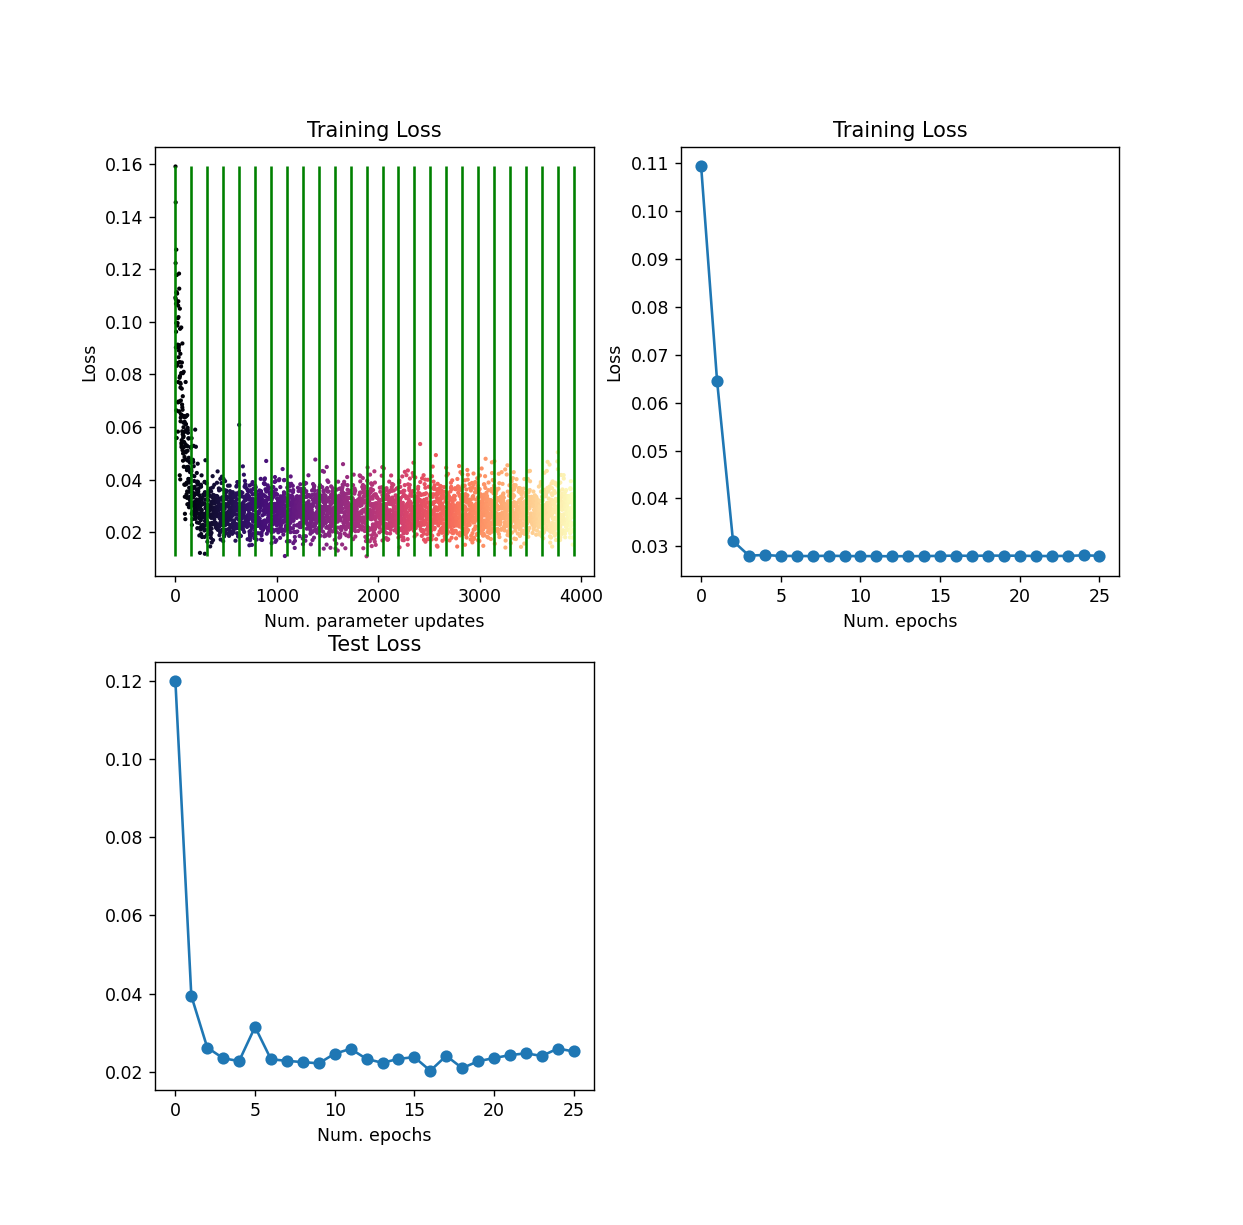

In [10]:
time = np.array([i for i in range(num_param_states)])

#plotting loss over training
plt.figure()
plt.subplot(2, 2, 1)
plt.title('Training Loss')
plt.xlabel('Num. parameter updates')
plt.ylabel('Loss')
plt.scatter(time, train_loss, c=cm.magma(time/(num_param_states-1)), s=2)
plt.vlines(epoch_indices, min(train_loss), max(train_loss), linestyle='solid', colors='g')

plt.subplot(2, 2, 2)
plt.title('Training Loss')
plt.xlabel('Num. epochs')
plt.ylabel('Loss')
#plt.plot(train_loss[[int(_) for _ in epoch_indices]], 'o-')
plt.plot(ep_train_loss, 'o-')

#plotting loss over testing
plt.subplot(2, 2, 3)
plt.title('Test Loss')
plt.xlabel('Num. epochs')
plt.plot(test_loss, 'o-')

# plt.subplot(2, 2, 4)
# plt.title('Test Acc.')
# plt.xlabel('Num. epochs')
# plt.plot(test_acc, 'o-')

In [11]:
"""
List of all available params from training:
    - param_states is np array (num_param_states, num_params) of model states
    - train_loss, test_loss are self explanatory; train_loss is per minibatch
    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch
    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam
    - steps is np array (num_param_states-1, num_params) of model steps
""" 

'\nList of all available params from training:\n    - param_states is np array (num_param_states, num_params) of model states\n    - train_loss, test_loss are self explanatory; train_loss is per minibatch\n    - epoch_indices is a np arr (num_epochs+1), epoch_indices[i] = param_state idx at end of ith epoch\n    - grads, m1s, m2s are np arrays (num_param_states, num_params) of grad, m1, m2 from adam\n    - steps is np array (num_param_states-1, num_params) of model steps\n'

In [12]:
from sklearn.decomposition import PCA
print('PCA fitting:')

pca = PCA(n_components=2)
pca.fit(param_states)
pca_embed = pca.transform(param_states)
print('components_ shape:', pca.components_.shape, '\nsamples shape:', param_states.shape, '\ntransformed shape:', pca_embed.shape)

print("PCA explains", pca.explained_variance_ratio_, '->', sum(pca.explained_variance_ratio_)*100, '% of variance')

PCA fitting:
components_ shape: (2, 2) 
samples shape: (3926, 2) 
transformed shape: (3926, 2)
PCA explains [0.95784608 0.04215392] -> 100.0 % of variance


<IPython.core.display.Javascript object>


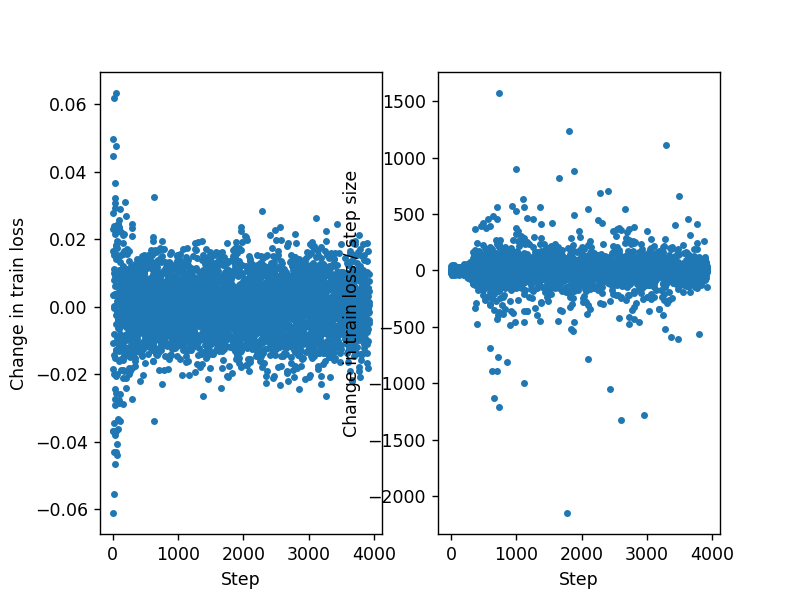

Text(0, 0.5, 'Change in train loss / step size')

In [13]:
#change in train loss per change in param (effective gradient)
change_train_loss = train_loss[1:] - train_loss[:-1]
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(change_train_loss, '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss")

plt.subplot(1, 2, 2)
plt.plot(change_train_loss/np.linalg.norm(steps, axis=-1), '.')
plt.xlabel("Step")
plt.ylabel("Change in train loss / step size")

Distance travelled in parameter space: 0.2796470376289468


<IPython.core.display.Javascript object>


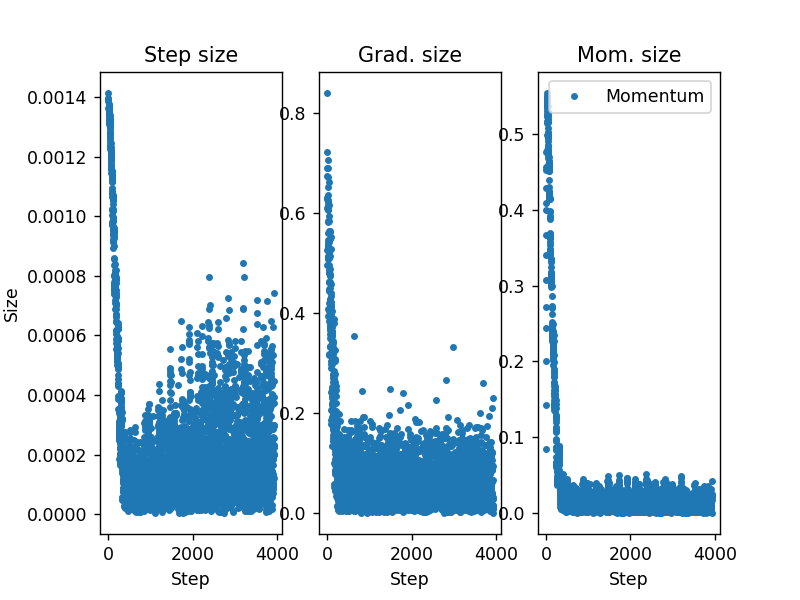

<IPython.core.display.Javascript object>


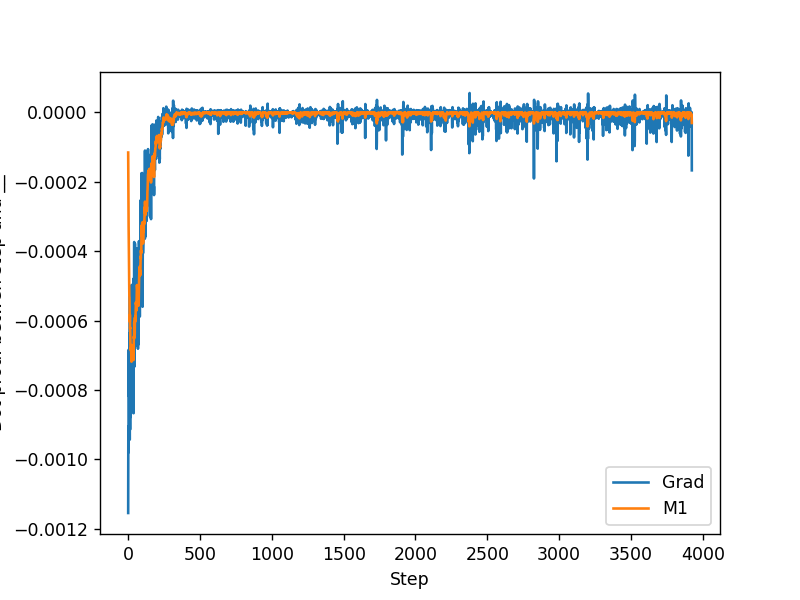

<IPython.core.display.Javascript object>


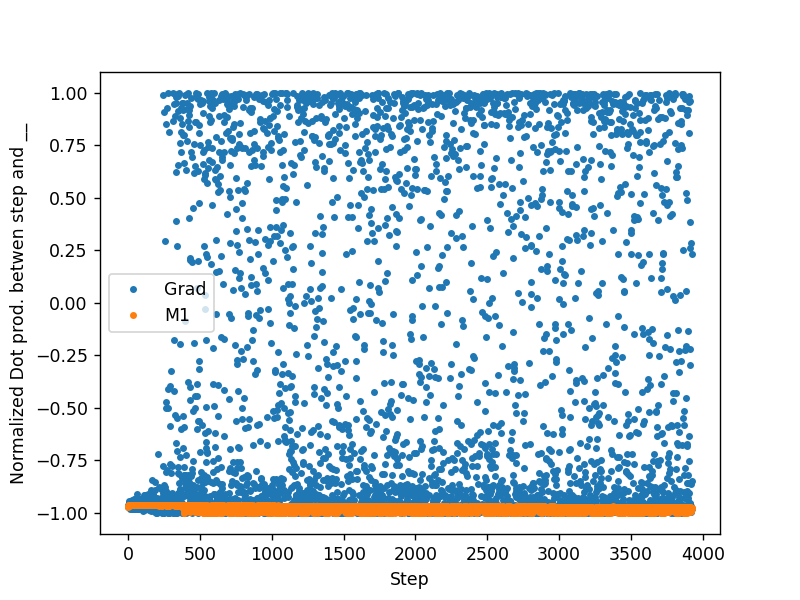

In [14]:
#Looking at properties of the steps the model took

#how far model has learned in param space
learning_length = np.linalg.norm(param_states[-1]-param_states[0])
print('Distance travelled in parameter space:', learning_length)

plt.figure()
plt.subplot(1, 3, 1)
plt.title("Step size")
plt.plot([i+1 for i in range(len(steps))], np.linalg.norm(steps, axis=-1), '.', label='Step')
plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 2)
plt.title("Grad. size")
plt.plot([i for i in range(len(grads))], np.linalg.norm(grads, axis=-1), '.', label='Grad')
#plt.ylabel('Size')
plt.xlabel("Step")

plt.subplot(1, 3, 3)
plt.title("Mom. size")
plt.plot([i for i in range(len(m1s))], np.linalg.norm(m1s, axis=-1), '.', label='Momentum')
#plt.ylabel('Size')
plt.xlabel("Step")
plt.legend()

plt.figure()
plt.ylabel('Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i]) for i in range(num_param_states-1)], label='Grad')
plt.plot([np.dot(steps[i], m1s[i]) for i in range(num_param_states-1)], label='M1')
plt.legend()

plt.figure()
plt.ylabel('Normalized Dot prod. betwen step and __')
plt.xlabel("Step")
plt.plot([np.dot(steps[i], grads[i])/(np.linalg.norm(grads[i])*np.linalg.norm(steps[i])) for i in range(num_param_states-1)], '.', label='Grad')
plt.plot([np.dot(steps[i], m1s[i])/(np.linalg.norm(m1s[i])*np.linalg.norm(steps[i])) for i in range(num_param_states-1)], '.', label='M1')
plt.legend()

<IPython.core.display.Javascript object>


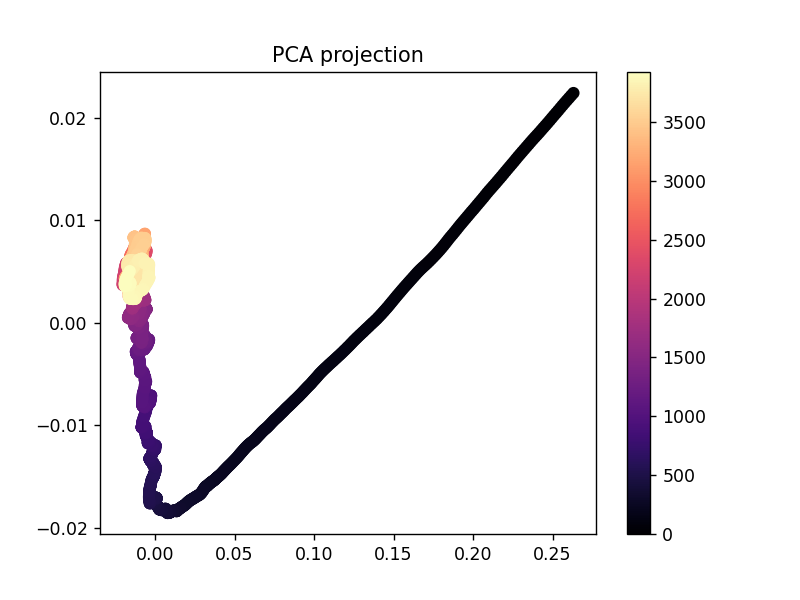

In [15]:
plt.figure()
plt.title('PCA projection')
plt.scatter(pca_embed[:, 0], pca_embed[:,1], c=[val for val in cmap(time/(num_param_states-1))])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))

In [16]:
#the two vectors from PCA, with shape (num_params)
pca_vec1 = pca.components_[0]
pca_vec2 = pca.components_[1]

pca_vec1_path = pca_embed[:, 0]
pca_vec2_path = pca_embed[:,1]

#setting initial model state to origin of PCA plot
orig_idx = 0
origin = param_states[orig_idx]
pca_vec1_path = pca_vec1_path - pca_vec1_path[orig_idx]*np.ones_like(pca_vec1_path)
pca_vec2_path = pca_vec2_path - pca_vec2_path[orig_idx]*np.ones_like(pca_vec2_path)

#applying PCA to gradients and m1s from Adam
pca.mean_ = np.zeros_like(pca.mean_)
grads_embed = pca.transform(grads)
m1s_embed = pca.transform(m1s)

<IPython.core.display.Javascript object>


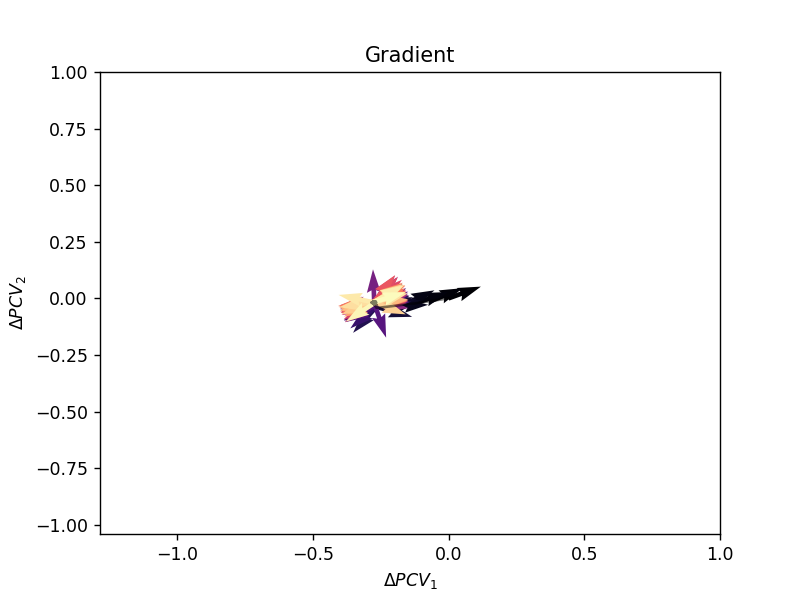

<IPython.core.display.Javascript object>


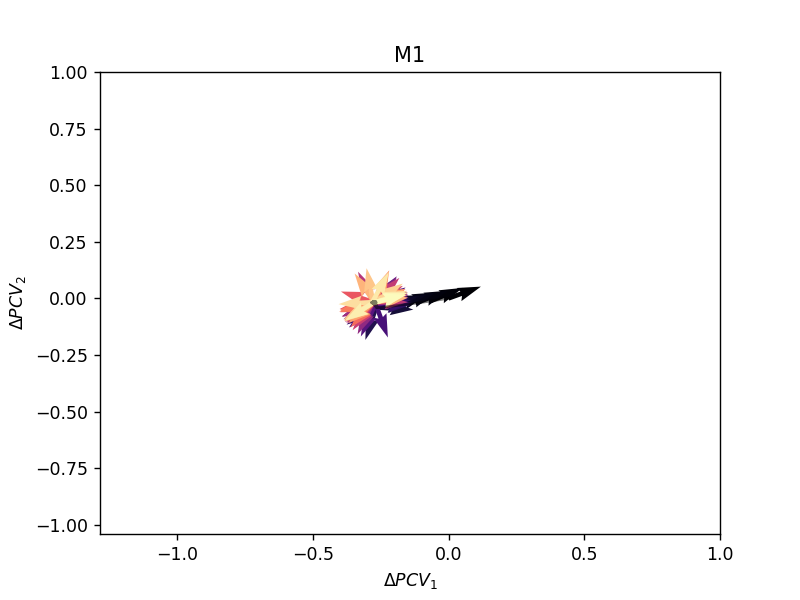

In [17]:
#can adjust pad to zoom in or out
pad = 1
resolution = 50

plt.figure()
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)

plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("Gradient")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], grads_embed[t,0], grads_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

plt.figure()
plt.xlim((min(pca_vec1_path)-pad, max(pca_vec1_path)+pad))
plt.ylim((min(pca_vec2_path)-pad, max(pca_vec2_path)+pad))
plt.title("M1")
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
#plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.plot(pca_vec1_path, pca_vec2_path, c='k', alpha=0.5)
for t in range(0, num_param_states-1, resolution):
    plt.quiver(pca_vec1_path[t], pca_vec2_path[t], m1s_embed[t,0], m1s_embed[t,1], color=cm.magma(t/(num_param_states-1)), angles='xy')

In [18]:
#calculating loss landscape
from mpl_toolkits.mplot3d import Axes3D

def loss_at(param_state):
    state = vector_to_state_dict(param_state, model)

    model.load_state_dict(state)

    this_loss = test(train_data, model, loss_fn)
    return this_loss

def calc_loss_grid(lb1, ub1, lb2, ub2, origin=origin, v1_bins=20, v2_bins=20, filename=r'loss_grid'):
    #data in scatter form (m, b, Loss)
    #loss_grid = np.zeros((100, 100))
    info = np.array([lb1, ub1, lb2, ub2, v1_bins, v2_bins])

    range1 = np.linspace(lb1, ub1, v1_bins)
    range2 = np.linspace(lb2, ub2, v2_bins)

    pnts1 = np.zeros((range1.size*range2.size))
    pnts2 = np.zeros((range1.size*range2.size))
    loss_pnts = np.zeros((range1.size*range2.size))

    idx = 0
    for v1 in range1:
        for v2 in range2:
            if idx != 0 and idx % 10==0:
                print(idx, '/', len(loss_pnts))
            #print(idx, "/", len(b_pnts))
            pnts1[idx] = v1
            pnts2[idx] = v2
            #print(origin.shape, pca_vec1.shape, pca_vec2.shape)
            loss_pnts[idx] = loss_at(origin + v1*pca_vec1 + v2*pca_vec2)
            idx += 1

#     with open(filename + '.npz', 'wb') as file:
#         np.savez(file, info=info, v1_pnts=pnts1, v2_pnts=pnts2, loss_pnts=loss_pnts)
        
    return pnts1, pnts2, loss_pnts


minimum = min(list(pca_vec1_path) + list(pca_vec2_path))
maximum = max(list(pca_vec1_path) + list(pca_vec2_path))
pad = 1*(maximum-minimum)
lb1 = np.mean(pca_vec1_path) - pad
ub1 = np.mean(pca_vec1_path) + pad
lb2 = np.mean(pca_vec2_path) - pad
ub2 = np.mean(pca_vec2_path) + pad

v1_bins = 20
v2_bins = 20

v1_pnts, v2_pnts, loss_pnts = calc_loss_grid(lb1, ub1, lb2, ub2, v1_bins=v1_bins, v2_bins=v2_bins)

10 / 400
20 / 400
30 / 400
40 / 400
50 / 400
60 / 400
70 / 400
80 / 400
90 / 400
100 / 400
110 / 400
120 / 400
130 / 400
140 / 400
150 / 400
160 / 400
170 / 400
180 / 400
190 / 400
200 / 400
210 / 400
220 / 400
230 / 400
240 / 400
250 / 400
260 / 400
270 / 400
280 / 400
290 / 400
300 / 400
310 / 400
320 / 400
330 / 400
340 / 400
350 / 400
360 / 400
370 / 400
380 / 400
390 / 400


<IPython.core.display.Javascript object>


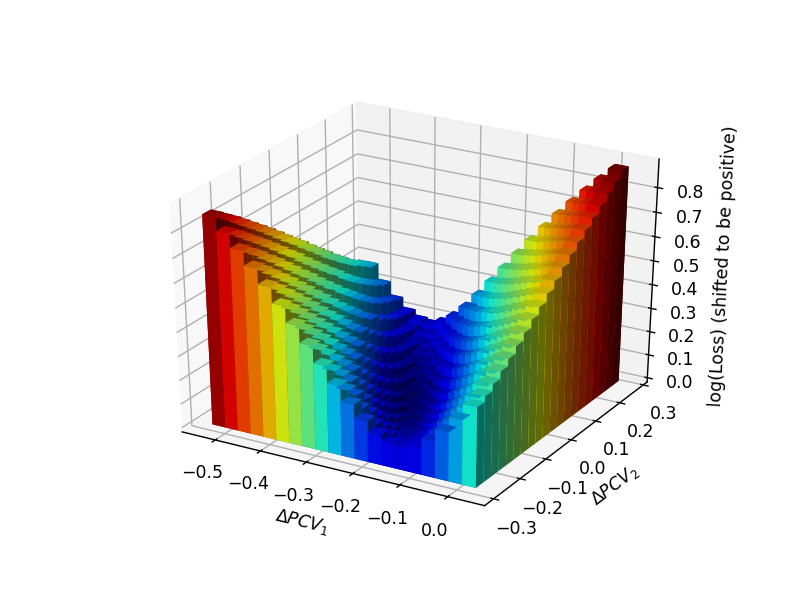

In [19]:
def bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, tuple):

    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')

    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(v2_pnts, v1_pnts, bins=tuple)
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

    #print(xpos)
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    #print(xpos)
    zpos = np.zeros_like(xpos)
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)
    #dz = loss_pnts

    #dz[np.argmin(dz)] = 10


    cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/(max_height-min_height)) for k in dz]

    ax.bar3d(ypos, xpos, zpos, dx, dy, dz, color=rgba, zsort='average')
    #plt.title("Loss LEGO plot")
    plt.xlabel("$\Delta PCV_{1}$")
    plt.ylabel("$\Delta PCV_{2}$")
    #ax.set_zlabel('Loss')
    ax.set_zlabel('log(Loss) (shifted to be positive)')
    #ax.zaxis.set_scale('log')
    #plt.show()
    return

# with open('loss_grid.npz', 'rb') as f:
#     npzfile = np.load(f)
#     info = npzfile['info']
#     v1_pnts = npzfile['v1_pnts']
#     v2_pnts = npzfile['v2_pnts']
#     loss_pnts = npzfile['loss_pnts']
# lb1 = info[0]
# ub1 = info[1]
# lb2 = info[2]
# ub2 = info[3]
# v1_bins = int(info[4])
# v2_bins = int(info[5])

bar_plot_3d(v1_pnts, v2_pnts, loss_pnts, (int(v1_bins),int(v2_bins)))

<IPython.core.display.Javascript object>


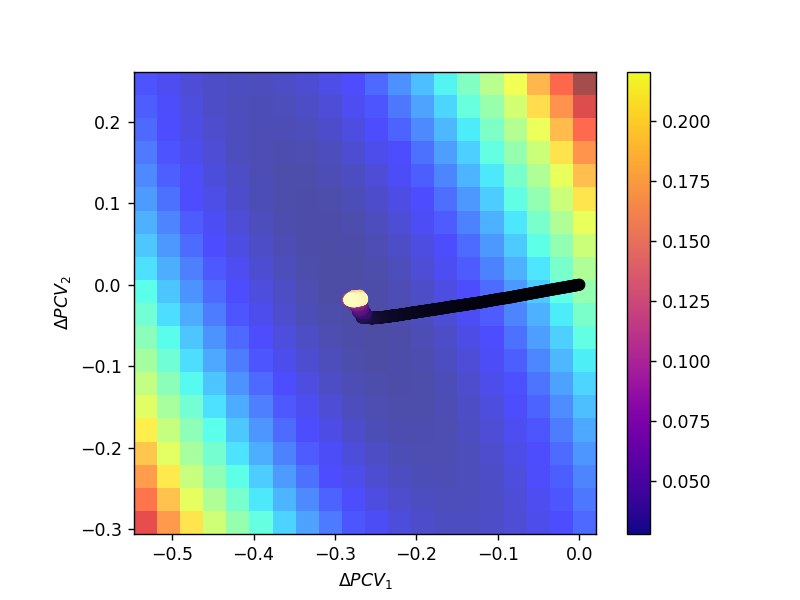

(-0.3060740129434739, 0.261193284777698)

In [20]:
#log scaling if wanted
#loss_pnts = np.log10(loss_pnts) + np.abs(min(np.log10(loss_pnts)))*np.ones_like(loss_pnts)

low = min(loss_pnts)
high = max(loss_pnts)
#rescaling elements of loss_pnts
loss_pnts_scaled = (loss_pnts - low*np.ones_like(loss_pnts))/(high-low)

plt.figure()
cmap1 = cm.plasma
norm1 = colors.Normalize(vmin=min(loss_pnts), vmax=max(loss_pnts))
plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap1))
im_loss = loss_pnts.reshape(v1_bins,v2_bins)

cmap = cm.viridis
norm1 = colors.Normalize(vmin=0, vmax=len(pca_vec1_path))

plt.imshow(np.flip(im_loss.T, axis=0), extent=[lb1,ub1,lb2,ub2], cmap=cm.jet, alpha=0.7)
plt.scatter(pca_vec1_path, pca_vec2_path, c=[cm.magma(i/len(pca_vec1_path)) for i in range(len(pca_vec1_path))], alpha=1, zorder=1)
#plt.scatter([250], [250], c=[(0,1,0)])
plt.xlabel('$\Delta PCV_{1}$')
plt.ylabel('$\Delta PCV_{2}$')
plt.xlim(lb1, ub1)
plt.ylim(lb2, ub2)